## 📊 IT24100269 De-duplication (Data Cleaning)

**Objective**: Remove exact duplicate rows (foundation for correctness).
#### **EDA**: Line chart of unique invoices per day (shows coverage/seasonality).

In [1]:
# --- Setup
!pip -q install openpyxl

import os, pandas as pd, numpy as np, matplotlib.pyplot as plt

# Where to save results (matches suggested repo style)
os.makedirs("../results/eda_visualization", exist_ok=True)
os.makedirs("../results/outputs", exist_ok=True)

xlsx_path = "../data/online_retail_II.xlsx"
sheets = ["Year 2009-2010", "Year 2010-2011"]

# Read the first sheet
dfs = pd.read_excel(xlsx_path, sheet_name=None, engine="openpyxl")
df = pd.concat(dfs.values(), ignore_index=True)

# Normalize column names: lower, strip spaces, replace spaces with underscores
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]
df.head()

,invoice,stockcode,description,quantity,invoicedate,price,customer_id,country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [64]:
# --- BEFORE/AFTER counts
n_before = len(df)
df_clean = df.drop_duplicates(keep="first").copy()
n_after = len(df_clean)
n_removed = n_before - n_after

print(f"Rows before: {n_before:,}")
print(f"Rows after : {n_after:,}")
print(f"Exact duplicates removed: {n_removed:,}")

# Save cleaned dataset
cleaned_path = "../results/outputs/cleaned_dataset.xlsx"
df_clean.to_excel(cleaned_path, index=False)
print("Saved:", cleaned_path)


Rows before: 1,067,371
Rows after : 1,033,036
Exact duplicates removed: 34,335
Saved: ../results/outputs/cleaned_dataset.xlsx
Saved: ../results/outputs/cleaned_dataset.xlsx


In [66]:
def detect_invoice_col(columns):
    cols = [c for c in columns if "invoice" in c and ("id" in c or "no" in c or "number" in c or c == "invoice")]
    if cols:
        pref = [c for c in cols if ("id" in c or "no" in c)]
        return pref[0] if pref else cols[0]
    # common fallbacks
    for common in ["invoice_no", "invoiceid", "invoice_number", "invoiceno", "invoice"]:
        if common in columns:
            return common
    return None

def detect_date_col(columns):
    cols = [c for c in columns if "date" in c]
    if cols:
        pref = [c for c in cols if "invoice" in c]  # prefer "invoice_date"
        return pref[0] if pref else cols[0]
    for common in ["invoice_date", "date"]:
        if common in columns:
            return common
    return None

invoice_col = detect_invoice_col(df_clean.columns.tolist())
date_col    = detect_date_col(df_clean.columns.tolist())

print("Detected invoice column:", invoice_col)
print("Detected date column   :", date_col)

# --- If detection fails, SET THESE MANUALLY:
# invoice_col = "invoice_no"
# date_col = "invoice_date"


Detected invoice column: invoice
Detected date column   : invoicedate


In [67]:
df_clean[date_col] = pd.to_datetime(df_clean[date_col], errors="coerce")
df_clean = df_clean.dropna(subset=[date_col]).copy()
df_clean[invoice_col] = df_clean[invoice_col].astype(str)

# Count UNIQUE invoices per calendar day (include returns; change filter if you want to exclude)
daily_unique = (
    df_clean
      .assign(date_only=df_clean[date_col].dt.date)
      .groupby("date_only")[invoice_col]
      .nunique()
      .reset_index(name="unique_invoices")
)

print("daily_unique rows:", len(daily_unique))
print(daily_unique.head())

daily_unique rows: 604
    date_only  unique_invoices
0  2009-12-01              166
1  2009-12-02              133
2  2009-12-03              150
3  2009-12-04              107
4  2009-12-05               32


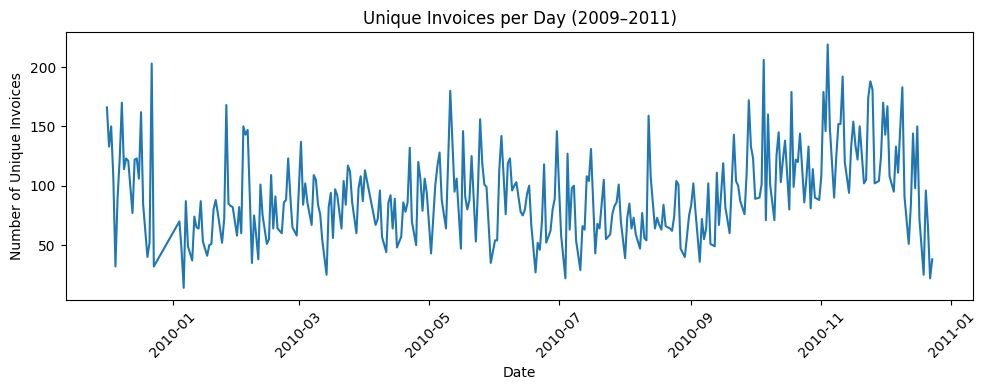

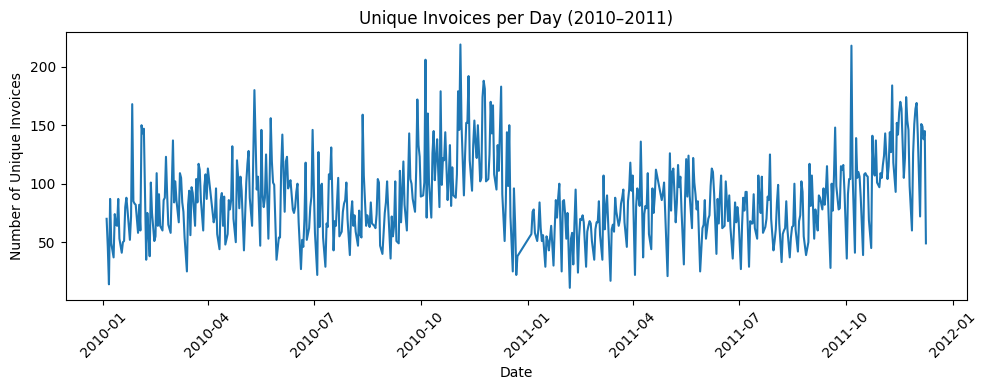

In [68]:
# Convert date_only column to datetime.date if not already
daily_unique["date_only"] = pd.to_datetime(daily_unique["date_only"])

# --- 1) Filter for 2009 to 2011
mask_2009_2010 = (
    (daily_unique["date_only"] >= "2009-01-01") &
    (daily_unique["date_only"] <= "2010-12-31")
)
daily_2009_2010 = daily_unique.loc[mask_2009_2010]

plt.figure(figsize=(10,4))
plt.plot(daily_2009_2010["date_only"], daily_2009_2010["unique_invoices"])
plt.title("Unique Invoices per Day (2009–2011)")
plt.xlabel("Date")
plt.ylabel("Number of Unique Invoices")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("../results/eda_visualization/IT24100269_unique_invoices_2009_2010.png", dpi=150)
plt.show()


# --- 2) Filter for 2010 to 2011
mask_2010_2011 = (daily_unique["date_only"] >= "2010-01-01") & (daily_unique["date_only"] <= "2011-12-31")
daily_2010_2011 = daily_unique.loc[mask_2010_2011]

plt.figure(figsize=(10,4))
plt.plot(daily_2010_2011["date_only"], daily_2010_2011["unique_invoices"])
plt.title("Unique Invoices per Day (2010–2011)")
plt.xlabel("Date")
plt.ylabel("Number of Unique Invoices")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("../results/eda_visualization/IT24100269_unique_invoices_2010_2011.png", dpi=150)
plt.show()

## 📊 IT24100344 Missing Value Handling

**Objective**: Remove rows with no customer id.
#### **EDA**: Revenue Share: With vs Without CustomerID

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [70]:
df = pd.read_excel("../results/outputs/cleaned_dataset.xlsx")

print("Dataset loaded successfully:", df.shape)
df.head()

Dataset loaded successfully: (1033036, 8)


,invoice,stockcode,description,quantity,invoicedate,price,customer_id,country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [ ]:
# Count missing values per column
df.isnull().sum()

# Specifically check CustomerID
missing_custid = df['customer_id'].isnull().sum()
print(f"Missing Customer IDs: {missing_custid}")

In [71]:
# has_id = 1 if CustomerID present, 0 if missing
df['has_id'] = df['customer_id'].notnull().astype(int)

df[['customer_id', 'has_id']].head(10)

,customer_id,has_id
0,13085.0,1
1,13085.0,1
2,13085.0,1
3,13085.0,1
4,13085.0,1
5,13085.0,1
6,13085.0,1
7,13085.0,1
8,13085.0,1
9,13085.0,1


In [72]:
# has_id = 1 if CustomerID present, 0 if missing
df['has_id'] = df['customer_id'].notnull().astype(int)

df[['customer_id', 'has_id']].head(10)

,customer_id,has_id
0,13085.0,1
1,13085.0,1
2,13085.0,1
3,13085.0,1
4,13085.0,1
5,13085.0,1
6,13085.0,1
7,13085.0,1
8,13085.0,1
9,13085.0,1


In [73]:
# Dataset with all rows (for general EDA)
df_all = df.copy()

# Dataset for RFM (drop rows without CustomerID)
df_rfm = df[df['customer_id'].notnull()].copy()

print("Original shape:", df.shape)
print("After dropping missing CustomerID:", df_rfm.shape)
df_rfm.to_csv("../results/outputs/IT24100344_missing.csv")

Original shape: (1033036, 9)
After dropping missing CustomerID: (797885, 9)


In [74]:
# Add a Revenue column
df['Revenue'] = df['quantity'] * df['price']

# Group by has_id flag to calculate revenue share
revenue_share = df.groupby('has_id')['Revenue'].sum()

print(revenue_share)


has_id
0    2.565542e+06
1    1.628999e+07
Name: Revenue, dtype: float64


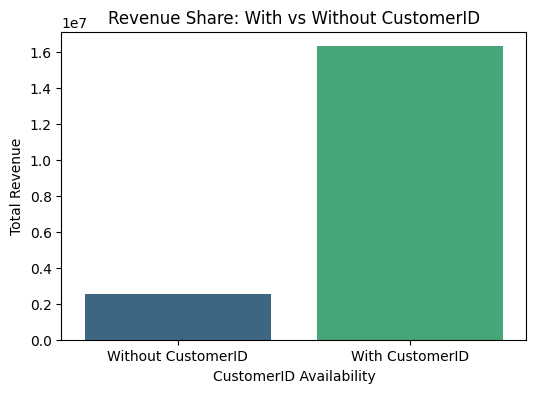

In [75]:
# Set style
plt.figure(figsize=(6,4))
sns.barplot(
    x=revenue_share.index,
    y=revenue_share.values,
    hue=revenue_share.index,   # <- fix warning
    palette="viridis",
    legend=False               # <- remove unnecessary legend
)

plt.xticks([0,1], ["Without CustomerID", "With CustomerID"])
plt.title("Revenue Share: With vs Without CustomerID")
plt.ylabel("Total Revenue")
plt.xlabel("CustomerID Availability")
plt.savefig("../results/eda_visualization/IT24100344_revenueshares")
plt.show()


## 📊 IT24100323 Outlier Handling

**Objective**: Cap extreme Quantity values using IQR/Winsor method (returns flagged separately but not part of this member’s role).
#### **EDA**: Boxplot of Quantity before vs after capping (clearer distribution).

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("../results/outputs/IT24100344_missing.csv")
df.head()

,Unnamed: 0,invoice,stockcode,description,quantity,invoicedate,price,customer_id,country,has_id
0,0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,1
1,1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,1
2,2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,1
3,3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,1
4,4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,1


In [77]:
Quantity_col = "quantity"
assert Quantity_col in df.columns, f"Quantity column not found. Columns: {list(df.columns)}"

df[Quantity_col] = pd.to_numeric(df[Quantity_col], errors="coerce")

In [78]:
q1 = df[Quantity_col].quantile(0.25)
q3 = df[Quantity_col].quantile(0.75)
iqr = q3 - q1
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr
q1, q3, iqr, lower, upper

(2.0, 12.0, 10.0, -13.0, 27.0)

In [79]:
is_outlier = (df[Quantity_col] < lower) | (df[Quantity_col] > upper)
df["is_Quantity_outlier"] = is_outlier
is_outlier.sum(), round(is_outlier.mean()*100, 2)

(53167, 6.66)

In [80]:
df["is_return"] = df[Quantity_col] < 0

In [81]:
df["Quantity_winsor"] = df[Quantity_col].clip(lower, upper)

In [82]:
out_path = "../results/outputs/02_outlier_capped_quantity.csv"
summary_path = "../results/outputs/Quantity_outlier_summary.csv"

summary = pd.DataFrame({
    "metric": ["Q1","Q3","IQR","Lower bound","Upper bound",
    "Total rows","Outliers (original)","Outlier rate (%)"],
    "value": [q1, q3, iqr, lower, upper, len(df), int(is_outlier.sum()),
    round(is_outlier.mean()*100,2)]
})

df.to_csv(out_path, index=False)
summary.to_csv(summary_path, index=False)
out_path, summary_path

('../results/outputs/02_outlier_capped_quantity.csv',
 '../results/outputs/Quantity_outlier_summary.csv')

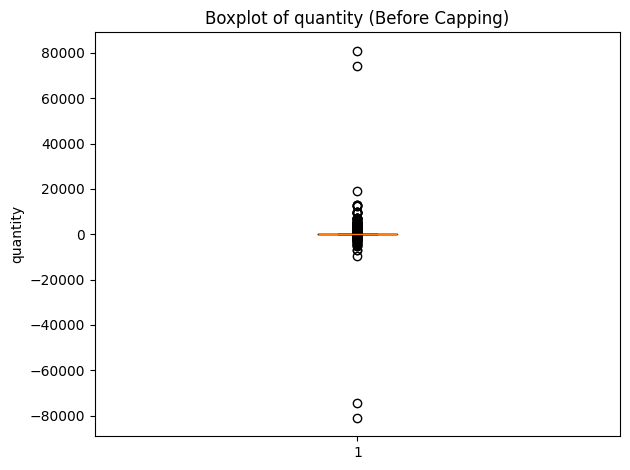

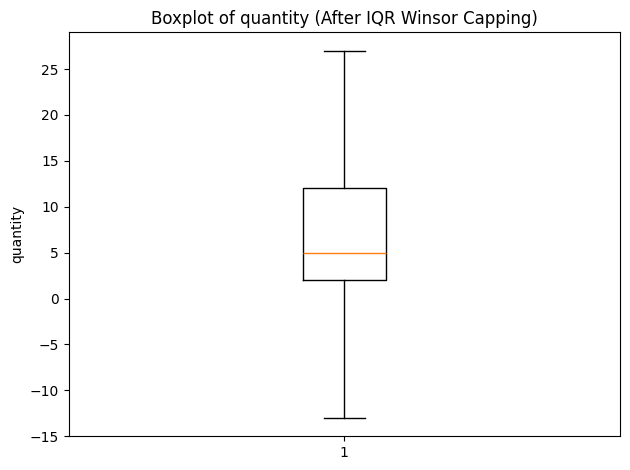

In [83]:
plt.figure()
plt.boxplot(df[Quantity_col].dropna(), vert=True)
plt.title(f"Boxplot of {Quantity_col} (Before Capping)")
plt.ylabel(Quantity_col)
plt.tight_layout()
plt.show()

plt.figure()
plt.boxplot(df["Quantity_winsor"].dropna(), vert=True)
plt.title(f"Boxplot of {Quantity_col} (After IQR Winsor Capping)")
plt.ylabel(Quantity_col)
plt.tight_layout()
plt.show()

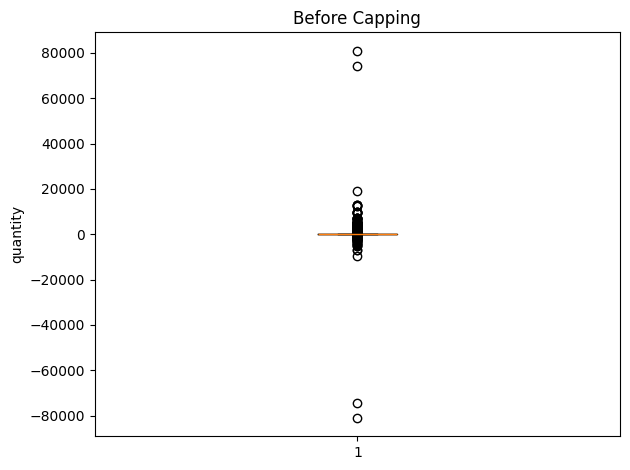

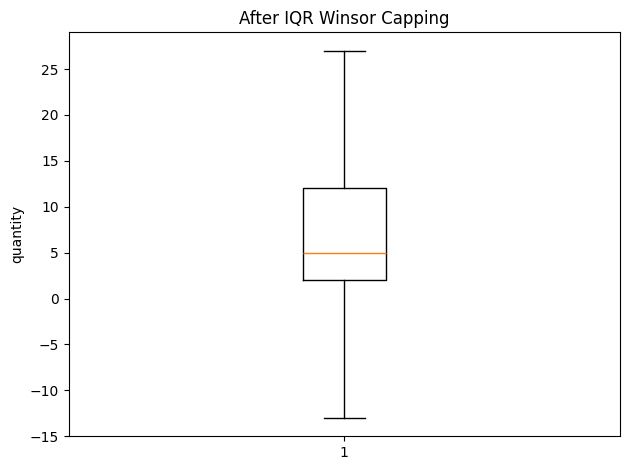

In [84]:
plt.figure(); plt.boxplot(df[Quantity_col].dropna(), vert=True)
plt.title(f"Before Capping"); plt.ylabel(Quantity_col); plt.tight_layout()
plt.savefig("../results/eda_visualization/boxplot_Quantity_before.png", dpi=200, bbox_inches="tight")
plt.figure(); plt.boxplot(df["Quantity_winsor"].dropna(), vert=True)
plt.title(f"After IQR Winsor Capping"); plt.ylabel(Quantity_col); plt.tight_layout()
plt.savefig("../results/eda_visualization/boxplot_Quantity_after.png", dpi=200, bbox_inches="tight")

## 📊 IT24100257 RFM Feature EngineeringOutlier Handling

**Objective**: Build R, F, M per customer using the latest date as snapshot (exclude returns for Frequency & Monetary).
#### **EDA**: Histograms of R, F, M.

In [85]:
import os
os.makedirs("../results/eda_visualizations", exist_ok=True)

In [87]:

import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("../results/outputs/02_outlier_capped_quantity.csv", parse_dates=["invoicedate"])

# Clean Customer ID & Invoice
df["customer_id"] = df["customer_id"].astype(int).astype(str)
df["invoice"] = df["invoice"].astype(str).str.strip()

# Create TotalPrice
df["TotalPrice"] = df["Quantity_winsor"] * df["price"]

# Snapshot date
snapshot_date = df["invoicedate"].max().normalize() + pd.Timedelta(days=1)

# Recency
last_purchase = (
    df.loc[~df["is_return"]]
      .groupby("customer_id")["invoicedate"]
      .max()
)
R = (snapshot_date - last_purchase).dt.days

# Frequency
F = (
    df.loc[~df["is_return"]]
      .groupby("customer_id")["invoicedate"]
      .nunique()
)

# Monetary
M = (
    df.loc[~df["is_return"]]
      .groupby("customer_id")["TotalPrice"]
      .sum()
      .clip(lower=0)
)

# Combine
rfm = pd.DataFrame({"R": R, "F": F, "M": M})
rfm.to_csv("../results/outputs/IT24100257_rfm_table.csv", index=True)

print(" RFM table created and saved as rfm_table.csv")
rfm.head()



 RFM table created and saved as rfm_table.csv


,R,F,M
customer_id,,,
12346,325,12,400.94
12347,2,8,4585.32
12348,75,5,1072.23
12349,18,4,4388.34
12350,310,1,334.40


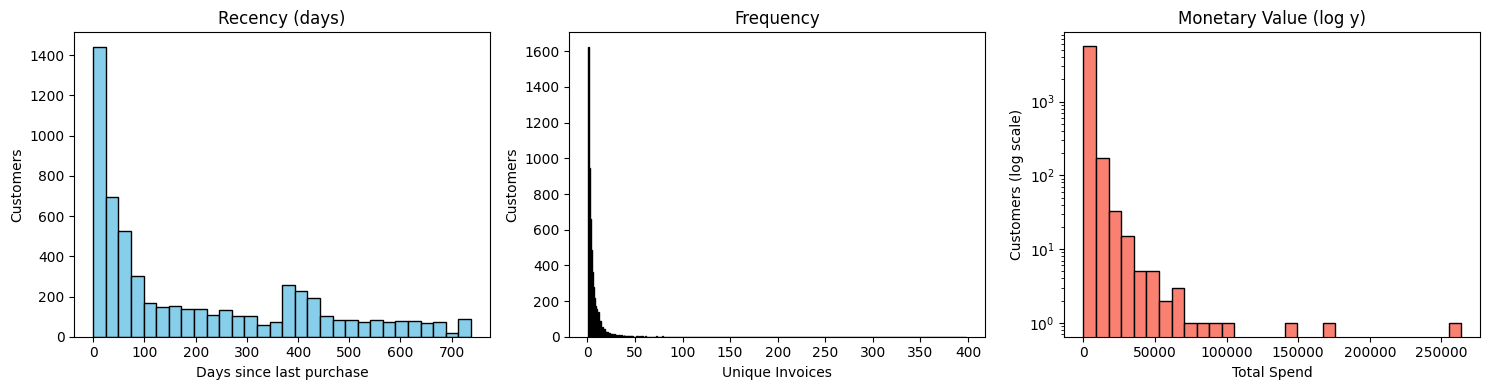

In [88]:
plt.figure(figsize=(15, 4))

# Recency
plt.subplot(1, 3, 1)
plt.hist(rfm["R"], bins=30, color="skyblue", edgecolor="black")
plt.title("Recency (days)")
plt.xlabel("Days since last purchase")
plt.ylabel("Customers")

# Frequency
plt.subplot(1, 3, 2)
plt.hist(rfm["F"], bins=range(1, rfm["F"].max() + 1), color="lightgreen", edgecolor="black")
plt.title("Frequency")
plt.xlabel("Unique Invoices")
plt.ylabel("Customers")

# Monetary
plt.subplot(1, 3, 3)
plt.hist(rfm["M"], bins=30, color="salmon", edgecolor="black", log=True)
plt.title("Monetary Value (log y)")
plt.xlabel("Total Spend")
plt.ylabel("Customers (log scale)")

plt.tight_layout()
plt.savefig("../results/eda_visualization/IT24100257_rfm_histograms.png")
plt.show()


## 📊 IT24100322 Feature Scaling

**Objective**: Apply StandardScaler to normalize RFM features (R, F, M) for clustering preparation.
#### **EDA**: Before vs After scaling comparison histogram showing the effect of standardization.

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import StandardScaler

# Load the RFM dataset from Kavindu's step
csv_path = "../results/outputs/IT24100257_rfm_table.csv"

PLOTS = Path("../results/eda_visualization")
OUTS = Path("../results/outputs")
PLOTS.mkdir(parents=True, exist_ok=True)
OUTS.mkdir(parents=True, exist_ok=True)

def save_fig(name: str):
    out = PLOTS / f"{"IT24100322"}_{name}.png"
    plt.tight_layout()
    plt.savefig(out, dpi=200, bbox_inches="tight")
    plt.show()
    plt.close()
    print(f"Saved: {out}")

# Load the RFM dataset
df = pd.read_csv(csv_path)
print("Loaded RFM data shape:", df.shape)
print("Columns:", df.columns.tolist())
print("\nRFM data preview:")
df.head()

Loaded RFM data shape: (5881, 4)
Columns: ['customer_id', 'R', 'F', 'M']

RFM data preview:


,customer_id,R,F,M
0,12346,325,12,400.94
1,12347,2,8,4585.32
2,12348,75,5,1072.23
3,12349,18,4,4388.34
4,12350,310,1,334.40


In [90]:
# Prepare RFM data for transformation and scaling
# Set CustomerID as index for easier processing
rfm = df.set_index("customer_id").copy()
print("RFM data structure:")
print(rfm.info())
print("\nRFM statistics:")
rfm.describe()

RFM data structure:
<class 'pandas.core.frame.DataFrame'>
Index: 5881 entries, 12346 to 18287
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   R       5881 non-null   int64  
 1   F       5881 non-null   int64  
 2   M       5881 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 183.8 KB
None

RFM statistics:


,R,F,M
count,5881.000000,5881.000000,5881.000000
mean,200.992858,6.267131,2155.678471
std,209.489651,12.927502,6405.844132
min,0.000000,1.000000,0.000000
25%,25.000000,1.000000,312.930000
50%,95.000000,3.000000,782.720000
75%,379.000000,7.000000,2016.140000
max,738.000000,398.000000,263734.680000


In [91]:
# Apply StandardScaler to RFM features for clustering
# StandardScaler normalizes features to have mean=0 and std=1
scaler = StandardScaler()
rfm[["R_scaled", "F_scaled", "M_scaled"]] = scaler.fit_transform(rfm[["R", "F", "M"]])

print("RFM data with scaled features:")
print(rfm[["R", "F", "M", "R_scaled", "F_scaled", "M_scaled"]].head())

print(f"\nScaling statistics:")
print(f"Original R: mean={rfm['R'].mean():.2f}, std={rfm['R'].std():.2f}")
print(f"Scaled R: mean={rfm['R_scaled'].mean():.2f}, std={rfm['R_scaled'].std():.2f}")
print(f"Original F: mean={rfm['F'].mean():.2f}, std={rfm['F'].std():.2f}")
print(f"Scaled F: mean={rfm['F_scaled'].mean():.2f}, std={rfm['F_scaled'].std():.2f}")
print(f"Original M: mean={rfm['M'].mean():.2f}, std={rfm['M'].std():.2f}")
print(f"Scaled M: mean={rfm['M_scaled'].mean():.2f}, std={rfm['M_scaled'].std():.2f}")

print(f"\nRFM with scaled features (shape: {rfm.shape}):")
rfm.head()

RFM data with scaled features:
               R   F        M  R_scaled  F_scaled  M_scaled
customer_id                                                
12346        325  12   400.94  0.591999  0.443501 -0.273951
12347          2   8  4585.32 -0.949974  0.134057  0.379317
12348         75   5  1072.23 -0.601479 -0.098027 -0.169149
12349         18   4  4388.34 -0.873592 -0.175388  0.348565
12350        310   1   334.40  0.520390 -0.407471 -0.284339

Scaling statistics:
Original R: mean=200.99, std=209.49
Scaled R: mean=0.00, std=1.00
Original F: mean=6.27, std=12.93
Scaled F: mean=-0.00, std=1.00
Original M: mean=2155.68, std=6405.84
Scaled M: mean=-0.00, std=1.00

RFM with scaled features (shape: (5881, 6)):


,R,F,M,R_scaled,F_scaled,M_scaled
customer_id,,,,,,
12346,325,12,400.94,0.591999,0.443501,-0.273951
12347,2,8,4585.32,-0.949974,0.134057,0.379317
12348,75,5,1072.23,-0.601479,-0.098027,-0.169149
12349,18,4,4388.34,-0.873592,-0.175388,0.348565
12350,310,1,334.40,0.520390,-0.407471,-0.284339


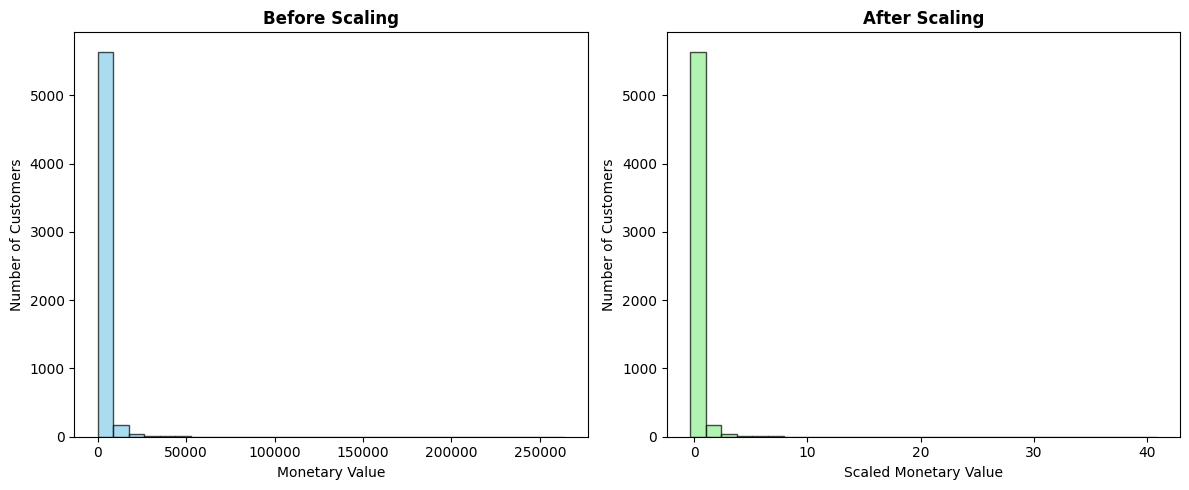

Saved: ..\results\eda_visualization\IT24100322_shahly_scaling_effect.png

=== SCALING SUMMARY ===
Input data: 5881 customers
Transformation applied: StandardScaler (mean=0, std=1)
Features scaled: R, F, M

Output saved: ..\results\outputs\05_rfm_scaled.csv
✅ Ready for clustering with standardized features!

Saved columns: ['customer_id', 'R', 'F', 'M', 'R_scaled', 'F_scaled', 'M_scaled']


,customer_id,R,F,M,R_scaled,F_scaled,M_scaled
0,12346,325,12,400.94,0.591999,0.443501,-0.273951
1,12347,2,8,4585.32,-0.949974,0.134057,0.379317
2,12348,75,5,1072.23,-0.601479,-0.098027,-0.169149


In [92]:
# EDA: Before and after scaling comparison
plt.figure(figsize=(12, 5))

# Before scaling
plt.subplot(1, 2, 1)
plt.hist(rfm["M"], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.title("Before Scaling", fontweight='bold')
plt.xlabel("Monetary Value")
plt.ylabel("Number of Customers")

# After scaling
plt.subplot(1, 2, 2)
plt.hist(rfm["M_scaled"], bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
plt.title("After Scaling", fontweight='bold')
plt.xlabel("Scaled Monetary Value")
plt.ylabel("Number of Customers")

save_fig("shahly_scaling_effect")

# Save the scaled RFM data
# Reset index to include CustomerID as a column
rfm_output = rfm.reset_index()

# Ensure CustomerID is the first column
cols = ["customer_id"] + [c for c in rfm_output.columns if c != "customer_id"]
rfm_output = rfm_output[cols]

# Save to CSV
output_path = OUTS / "05_rfm_scaled.csv"
rfm_output.to_csv(output_path, index=False)

print(f"\n=== SCALING SUMMARY ===")
print(f"Input data: {len(rfm)} customers")
print(f"Transformation applied: StandardScaler (mean=0, std=1)")
print(f"Features scaled: R, F, M")
print(f"\nOutput saved: {output_path}")
print(f"✅ Ready for clustering with standardized features!")

# Verify the saved file
check_df = pd.read_csv(output_path, nrows=3)
print(f"\nSaved columns: {list(check_df.columns)}")
check_df

## 📊 IT24100258 Customer Filtering

**Objective**: Remove noise customers with very low engagement to improve clustering quality

### Key Implementation:
- **Filter Criteria**: `Frequency > 1 AND Monetary > 0`
- **Input**: `05_rfm_scaled.csv` (transformed & scaled RFM data)
- **Output**: `06_filtered_customers_enhanced.csv` (clean dataset ready for clustering)

### Results:
- Applied strict filtering to remove one-time buyers and zero-spend customers
- Enhanced dataset with customer value segmentation
- Generated comprehensive EDA visualizations for filtering analysis

### EDA Visualizations:
1. **Customer filtering results comparison** - Bar chart showing kept vs removed customers
2. **Frequency distribution comparison** - Before/after filtering histograms

- **Output**: High-quality customer dataset optimized for clustering algorithms
- **Impact**: Improved data quality by removing noise customers for better segmentation results

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [94]:
csv_path = "../results/outputs/05_rfm_scaled.csv"
PLOTS = Path("../results/eda_visualization")
OUTS = Path("../results/outputs")

In [95]:
#function to save the image files in eda_visualization folder
def save_fig(name):
    out = PLOTS / f"{"IT24100258_Pasan"}_{name}.png"
    plt.tight_layout()
    plt.savefig(out, dpi=200, bbox_inches="tight")
    plt.show()
    plt.close()
    print(f"Saved: {out}")

In [96]:
# Load the scaled RFM dataset
df = pd.read_csv(csv_path)
print("Loaded RFM data shape:", df.shape)
print("Columns:", df.columns.tolist())
print(f"\nSuccess! Loaded {len(df.columns)} columns.")
print("Data includes original R,F,M + scaled features")

Loaded RFM data shape: (5881, 7)
Columns: ['customer_id', 'R', 'F', 'M', 'R_scaled', 'F_scaled', 'M_scaled']

Success! Loaded 7 columns.
Data includes original R,F,M + scaled features


In [97]:
# Check the data structure
print("RFM data info:")
df.info()
print("\nSample of data:")
print("- Original features: R, F, M")
print("- Scaled features: R_scaled, F_scaled, M_scaled")
df_rfm = df.set_index("customer_id")

RFM data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5881 entries, 0 to 5880
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   customer_id  5881 non-null   int64  
 1   R            5881 non-null   int64  
 2   F            5881 non-null   int64  
 3   M            5881 non-null   float64
 4   R_scaled     5881 non-null   float64
 5   F_scaled     5881 non-null   float64
 6   M_scaled     5881 non-null   float64
dtypes: float64(4), int64(3)
memory usage: 321.7 KB

Sample of data:
- Original features: R, F, M
- Scaled features: R_scaled, F_scaled, M_scaled


In [98]:
# Check for customers with F=1 or M=0
print(f"\nCustomers needing filtering:")
print(f"- Customers with F=1: {(df_rfm["F"] == 1).sum():,}")
print(f"- Customers with M=0: {(df_rfm["M"] == 0).sum():,}")
print(f"- Customers with F=1 OR M=0: {((df_rfm["F"] == 1) | (df_rfm["M"] == 0)).sum():,}")
cust = df_rfm.copy()
cust.head()


Customers needing filtering:
- Customers with F=1: 1,625
- Customers with M=0: 3
- Customers with F=1 OR M=0: 1,625


,R,F,M,R_scaled,F_scaled,M_scaled
customer_id,,,,,,
12346,325,12,400.94,0.591999,0.443501,-0.273951
12347,2,8,4585.32,-0.949974,0.134057,0.379317
12348,75,5,1072.23,-0.601479,-0.098027,-0.169149
12349,18,4,4388.34,-0.873592,-0.175388,0.348565
12350,310,1,334.40,0.520390,-0.407471,-0.284339


In [99]:
f_before = cust["F"].copy()
m_before = cust["M"].copy()

filter_condition = (cust["F"] > 1) & (cust["M"] > 0)
cust["Status"] = np.where(filter_condition, "Keep", "Remove")

print("Customer filtering results:")
counts = (
    cust["Status"].value_counts()
    .reindex(["Keep", "Remove"])
    .fillna(0)
    .astype(int)
)
kept, removed = counts["Keep"], counts["Remove"]
total = kept + removed

print(f"- Kept: {kept} ({kept/total*100:.1f}%)")
print(f"- Removed: {removed} ({removed/total*100:.1f}%)")
print(f"- Total: {total}")

Customer filtering results:
- Kept: 4256 (72.4%)
- Removed: 1625 (27.6%)
- Total: 5881


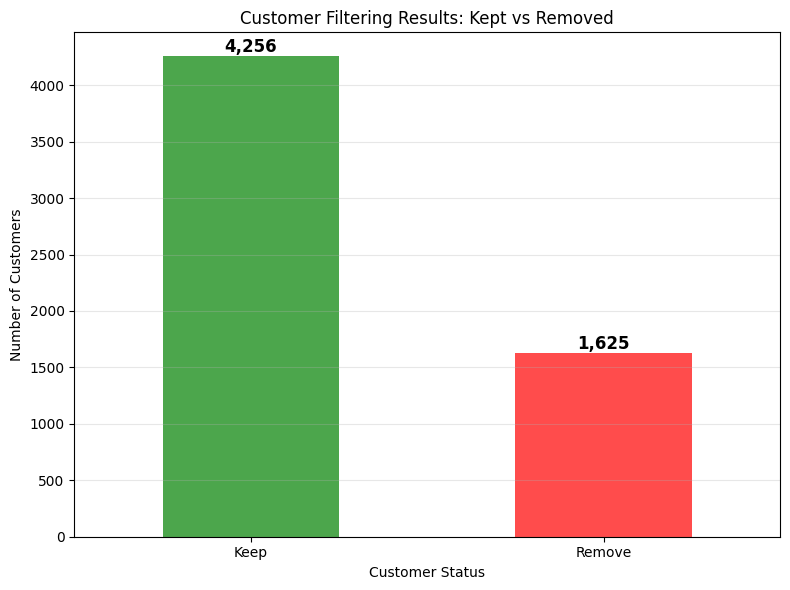

Saved: ..\results\eda_visualization\IT24100258_Pasan_customer_filtering_results.png


In [100]:
# EDA 1: Bar chart of customers removed vs kept
plt.figure(figsize=(8, 6))
ax = counts.plot(
    kind="bar", 
    rot=0, 
    title="Customer Filtering Results: Kept vs Removed",
    color=['green', 'red'],
    alpha=0.7
)

# Add value labels on bars
for p in ax.patches:
    height = int(p.get_height())
    ax.annotate(f'{height:,}',
                (p.get_x() + p.get_width()/2, p.get_height()),
                ha="center", va="bottom", fontsize=12, fontweight='bold')

plt.xlabel("Customer Status")
plt.ylabel("Number of Customers")
plt.grid(axis='y', alpha=0.3)
save_fig("customer_filtering_results")

In [101]:
# Prepare data for frequency histogram comparison
F_after = cust.loc[filter_condition, "F"]

# Set bins for histogram (ensure meaningful range)
max_f = int(max(f_before.max(), F_after.max())) if len(F_after) > 0 else int(f_before.max())
bins = np.arange(1, min(max_f + 2, 21))  # Limit to 20 for readability

print(f"Frequency range: 1 to {max_f}")
print(f"Customers before filtering: {len(f_before)}")
print(f"Customers after filtering: {len(F_after)}")

Frequency range: 1 to 398
Customers before filtering: 5881
Customers after filtering: 4256


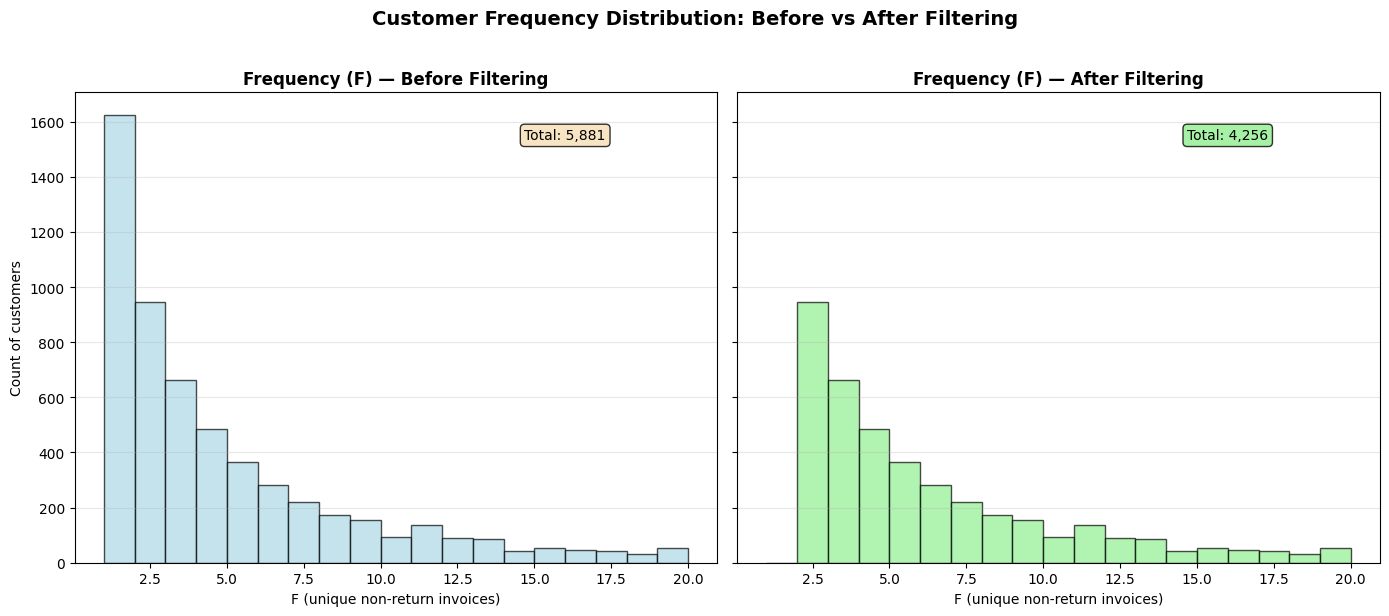

Saved: ..\results\eda_visualization\IT24100258_Pasan_frequency_before_after_filtering.png


In [102]:
# EDA 2: Histogram of Frequency before vs after filtering
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# BEFORE filtering
axes[0].hist(f_before, bins=bins, alpha=0.7, color='lightblue', edgecolor='black')
axes[0].set_title("Frequency (F) — Before Filtering", fontsize=12, fontweight='bold')
axes[0].set_xlabel("F (unique non-return invoices)")
axes[0].set_ylabel("Count of customers")
axes[0].grid(axis='y', alpha=0.3)
axes[0].text(0.7, 0.9, f'Total: {len(f_before):,}', transform=axes[0].transAxes, 
             bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.8))

# AFTER filtering
axes[1].hist(F_after, bins=bins, alpha=0.7, color='lightgreen', edgecolor='black')
axes[1].set_title("Frequency (F) — After Filtering", fontsize=12, fontweight='bold')
axes[1].set_xlabel("F (unique non-return invoices)")
axes[1].grid(axis='y', alpha=0.3)
axes[1].text(0.7, 0.9, f'Total: {len(F_after):,}', transform=axes[1].transAxes,
             bbox=dict(boxstyle="round", facecolor='lightgreen', alpha=0.8))

fig.suptitle("Customer Frequency Distribution: Before vs After Filtering", 
             y=1.02, fontsize=14, fontweight='bold')
save_fig("frequency_before_after_filtering")

In [103]:
# Save filtered customers with enhanced features for clustering
filtered_customers = cust.loc[filter_condition].copy()
filtered_customers_output = filtered_customers.reset_index()
filtered_customers_output.to_csv(OUTS / "06_filtered_customers_enhanced.csv", index=False)

print(f"\n=== CUSTOMER FILTERING SUMMARY ===")
print(f"Kept: {filter_condition.sum():,} customers ({filter_condition.sum()/len(cust)*100:.1f}%)")
print(f"Removed: {(~filter_condition).sum():,} customers ({(~filter_condition).sum()/len(cust)*100:.1f}%)")
print(f"\nOutput for clustering: 06_filtered_customers_enhanced.csv")
print(f"Features: Original (R,F,M) + Scaled features (ready for clustering)")
print(f"✅ Ready for clustering algorithms")


=== CUSTOMER FILTERING SUMMARY ===
Kept: 4,256 customers (72.4%)
Removed: 1,625 customers (27.6%)

Output for clustering: 06_filtered_customers_enhanced.csv
Features: Original (R,F,M) + Scaled features (ready for clustering)
✅ Ready for clustering algorithms
